<a href="https://colab.research.google.com/github/takaito1/car1/blob/main/car1_boxmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# car1: Stochastic ocean carbon box model

In [ ]:
pip install PyCO2SYS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PyCO2SYS

In [ ]:
# set up parameters
# thickness of the surface layer
h = 50
# thickness of the deep layer
H = 500
# biological export rate (1/100 days)
kbio = 1/(86400*100) # 100 day biological timescale
# mean vertical velocity
w0 = 1e-6 # upwelling / downwelling
# initial conditions
Pini = [0.5, 2]
Cini = [1900, 2200]
# Alkalinity
Alk = 2200
# SST
T = 15
Tseas = 3 # if desired, add seasonality
# salinity
S = 35
# gas exchange rate, a.k.a. piston velocity = 2000m/yr
sec2yr = 1/(86400*365)
G = 2000*sec2yr
#
# 1% increase per year after 90 year
pco2atm0=360
pco2inc=2
tstart=90
#
result0=PyCO2SYS.sys(par1=Alk,par2=Cini[0], par1_type=1, par2_type=2, temperature=15)
result1=PyCO2SYS.sys(par1=Alk,par2=Cini[0], par1_type=1, par2_type=2, temperature=16)
dKHdT = - result0['k_CO2'] + result1['k_CO2']

In [ ]:
# set up time stepping parameters
Nt = int(365/5*120)
dt = 5*86400
eps = np.random.normal(0,w0*3,Nt)

In [ ]:
# Initialization
time=np.zeros(Nt)
# prognostic variables
P=np.zeros((2,Nt))
C=np.zeros((2,Nt))
# diagnostic variables
pco2=np.zeros(Nt)
fgco2=np.zeros(Nt)
ncp=np.zeros(Nt)
transp=np.zeros(Nt)
pco2atm=np.zeros(Nt)
#
dPdt=np.zeros((2,Nt))
dCdt=np.zeros((2,Nt))
P[:,0]=Pini
C[:,0]=Cini

In [ ]:
# Time stepping loop
result=PyCO2SYS.sys(par1=Alk,par2=Cini[0], par1_type=1, par2_type=2)
KH0=result['k_CO2']
K1=result['k_carbonic_1']
K2=result['k_carbonic_2']
pco2[0]=result['pCO2']
fgco2[0]=G*KH0*(pco2[0]-360)/h
#
for n in range(Nt-1):
    w=np.max([0,w0+eps[n]])
    pco2atm[n]=pco2atm0 + pco2inc*np.max([0,time[n]-tstart])
    KH=KH0-dKHdT*Tseas*np.cos(time[n]*2*np.pi)
    time[n+1]=dt*n*sec2yr
    # nutrient
    dPdt[0,n] = w/h*(P[1,n]-P[0,n]) - kbio*P[0,n]
    dPdt[1,n] = -w/H*(P[1,n]-P[0,n]) + kbio*P[0,n]*h/H
    P[:,n+1]=P[:,n] + dt*dPdt[:,n]
    # carbon
    HCO3=2*C[0,n]-Alk
    CO3=Alk-C[0,n]
    co2 = K2/K1*HCO3**2/CO3
    #
    ncp[n]=kbio*P[0,n]*110*h
    transp[n]=w*(C[1,n]-C[0,n])
    pco2[n] = co2/KH
    dCdt[0,n] = w/h*(C[1,n]-C[0,n]) - kbio*P[0,n]*110 - G*KH*(pco2[n]-pco2atm[n])/h
    dCdt[1,n] = -w/H*(C[1,n]-C[0,n]) + kbio*P[0,n]*110*h/H
    fgco2[n+1]=G*KH*(pco2[n]-pco2atm[n])
    C[:,n+1]=C[:,n] + dt*dCdt[:,n]

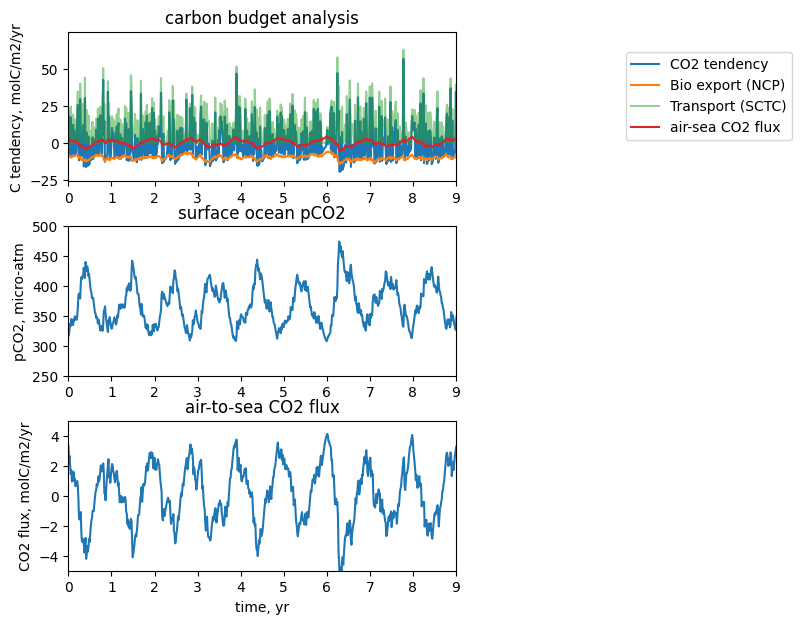

In [ ]:
# plot the output
# last 10 years
fig=plt.figure(figsize=(5,7))
ax=fig.subplots(3,1)
plt.subplots_adjust(hspace=.3,wspace=0)
ax=ax.flatten()
fac = 1.025e-3*365*86400
#
ax[0].plot(time-90,fac*dCdt[0,:]*h,label='CO2 tendency')
ax[0].plot(time-90,-ncp*fac,label='Bio export (NCP)')
ax[0].plot(time-90,transp*fac,alpha=.5,label='Transport (SCTC)')
#ax[0].plot(time-90,(dCdt[0,:]*h - transp + fgco2 + ncp)*fac,linewidth=2,color='k',label='Residual')
ax[0].plot(time-90,-fgco2*fac,label='air-sea CO2 flux')
#plt.ylim(-1000,1000)
ax[0].set_xlim(0,9)
ax[0].set_ylabel('C tendency, molC/m2/yr')
#ax[0].set_xlabel('time, yr')
ax[0].set_title('carbon budget analysis')
ax[0].legend(bbox_to_anchor=(1.42,.23))
#
ax[1].plot(time-90,pco2)
ax[1].set_xlim(0,9)
ax[1].set_ylim(250,500)
ax[1].set_ylabel('pCO2, micro-atm')
ax[1].set_title('surface ocean pCO2')
#ax[1].set_xlabel('time, yr')
#
ax[2].plot(time-90,-fgco2*fac)
ax[2].set_xlim(0,9)
ax[2].set_ylim(-5,5)
ax[2].set_ylabel('CO2 flux, molC/m2/yr')
ax[2].set_title('air-to-sea CO2 flux')
ax[2].set_xlabel('time, yr')
#
plt.savefig('model_output.pdf',bbox_inches='tight')

## Now, plot the result using the AR-1 framework

In [ ]:
# Now integrate the AR-1 model
result=PyCO2SYS.sys(par1=Alk,par2=C[0,-1], par1_type=1, par2_type=2)
alpha = result['revelle_factor']*result['CO2']/C[0,-1]
fatm=np.zeros(Nt)
ftrans = -alpha*transp/h # transport divergence is negative of convergence
fbio   = -alpha*ncp/h
fatm[:-1]   = KH0*(pco2atm[1:]-pco2atm[:-1])/dt
ftemp     = -2*np.pi/(365*86400)*dKHdT*pco2atm*Tseas*np.sin(time*2*np.pi)
#
Ftrans=np.zeros(Nt)
Fbio=np.zeros(Nt)
Ftemp=np.zeros(Nt)
Fatm =np.zeros(Nt)
lbd=G*alpha/h
#
for n in range(Nt-1):
    Ftrans[n+1]=Ftrans[n]-dt*lbd*Ftrans[n]+dt*G*(+ftrans[n])
    Fbio[n+1]=Fbio[n]-dt*lbd*Fbio[n]+dt*G*(-fbio[n])
    Ftemp[n+1]=Ftemp[n]-dt*lbd*Ftemp[n]+dt*G*(-ftemp[n])
    Fatm[n+1]=Fatm[n]-dt*lbd*Fatm[n]+dt*G*(fatm[n])

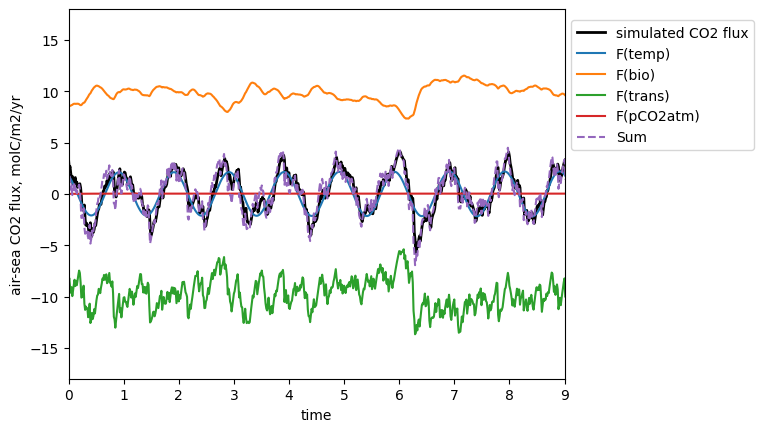

In [ ]:
plt.plot(time-90,-fgco2*fac,color='k',linewidth=2,label='simulated CO2 flux')
plt.plot(time-90,Ftemp*fac,label='F(temp)')
plt.plot(time-90,Fbio*fac,label='F(bio)')
plt.plot(time-90,Ftrans*fac,label='F(trans)')
plt.plot(time-90,Fatm*fac,label='F(pCO2atm)')
plt.plot(time-90,(Ftrans+Fbio+Ftemp+Fatm)*fac,'--',label='Sum')
plt.xlim(0,9)
plt.ylim(-18,18)
plt.legend(bbox_to_anchor=(1,.6))
plt.ylabel('air-sea CO2 flux, molC/m2/yr')
plt.xlabel('time')
plt.savefig('ar1_framework.pdf',bbox_inches='tight')